## 김성범 교수 ARIAM 실습 내용 


In [82]:
!pip install pandas_datareader


In [83]:
!pip install pmdarima

In [84]:

import os 
import pandas as pd 
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima.arima import auto_arima

import seaborn as sns

In [85]:
%matplotlib inline
import itertools

## 해볼 실습 

* 1949 -1960 비행기 탑승객 수에 대한 시계열 데이터 
* 주가 예측 

In [86]:
# 비행기 탑승 승객 시계열 데이터 

data = pd.read_csv("./ARIMA_data/airline-passengers.csv")

data=data.rename(columns={"Month":"month","#Passengers":"passengers"})
data["month"] = pd.to_datetime(data["month"])
data = data.set_index("month")
data

,Passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


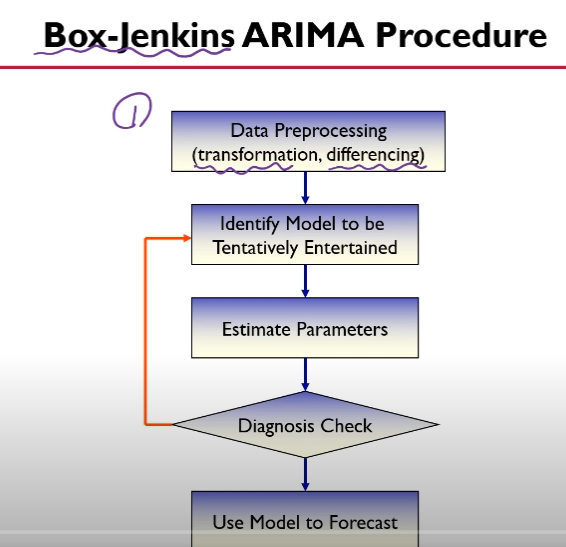

## Data preprocessing 

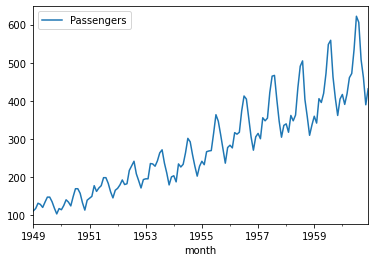

In [87]:
fig = data.plot()  # non stational data임을 알수있다 
# Trend : 데이터가 장기적으로 증가하거나 감소할때 
# Cycle : 고정된 빈도가 아닌 형태로 증가나 감소하는 모습 보일때 


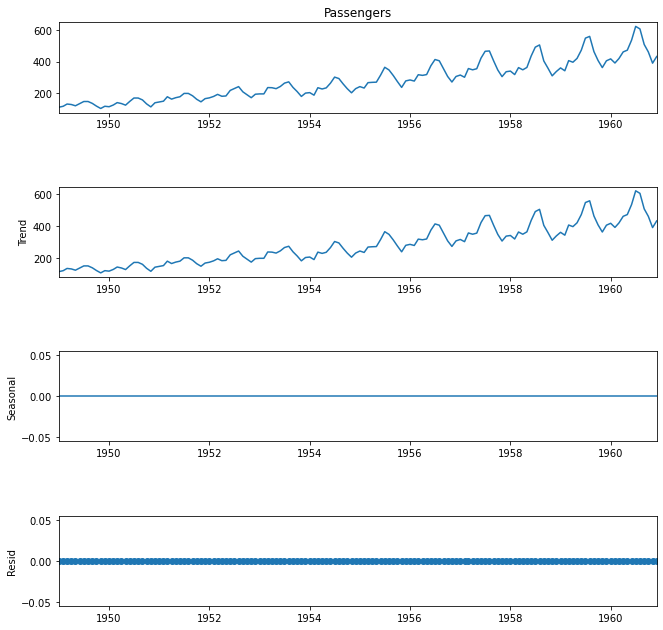

In [88]:

decomposition = sm.tsa.seasonal_decompose(data["Passengers"],model ="additive",period=1)

fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

# 1 obserbe
# 2 trend 
# 3 seasonal 
# 4 redisual

## identify model to be Tentatively Entertaineted

In [89]:
train_data,test_data = train_test_split(data,test_size=0.2,shuffle=False)

C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


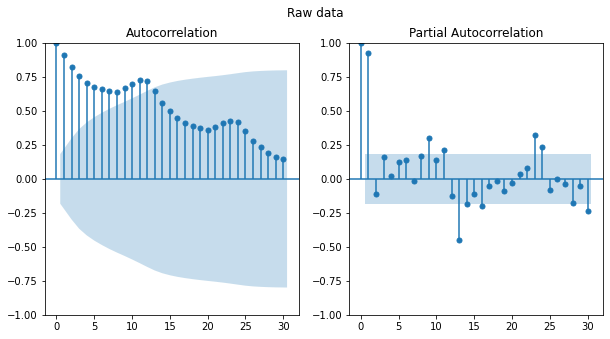

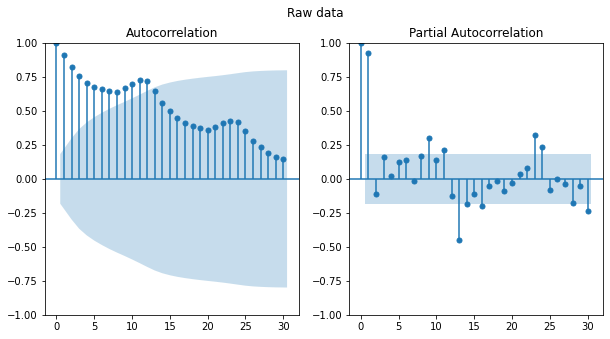

In [90]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

fig.suptitle("Raw data")
# acf, pacf plt 그리기 

plot_acf(train_data.values.squeeze(),lags=30,ax=ax[0])
plot_pacf(train_data.values.squeeze(),lags=30,ax=ax[1])

## Differencing 

현 시점에서 d 시점 이전 데이터를 빼기 때문에 반드시 결측치에 대한 처리가 필요하다 


In [91]:
# differencing 

diff_train_data = train_data.copy()
diff_train_data = diff_train_data["Passengers"].diff()
diff_train_data = diff_train_data.dropna() # 결측치 제거 

print("########RAW DATA #############")
print(train_data)
print("########## Difference DATA ##############")
print(diff_train_data)



########RAW DATA #############
            Passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
########## Difference DATA ##############
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: Passengers, Length: 114, dtype: float64


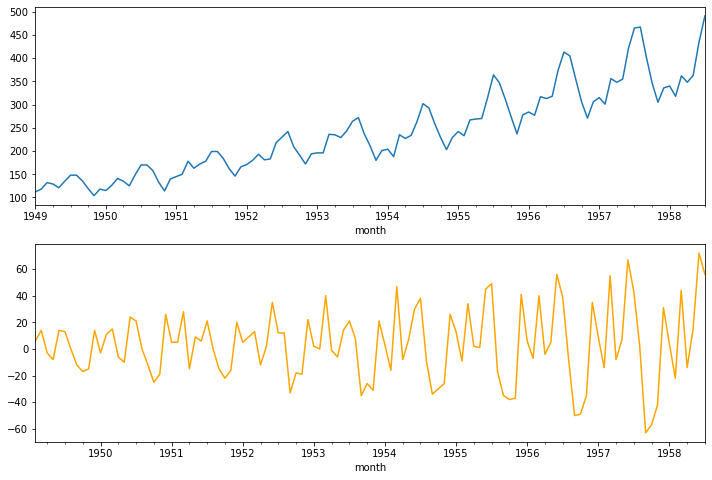

In [92]:
# Differencing plot 

plt.figure(figsize=(12,8))
plt.subplot(211)
train_data["Passengers"].plot()


plt.subplot(212)
diff_train_data.plot(color="orange")
plt.show()

C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


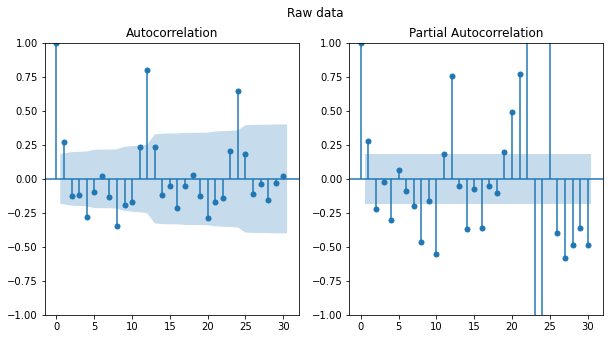

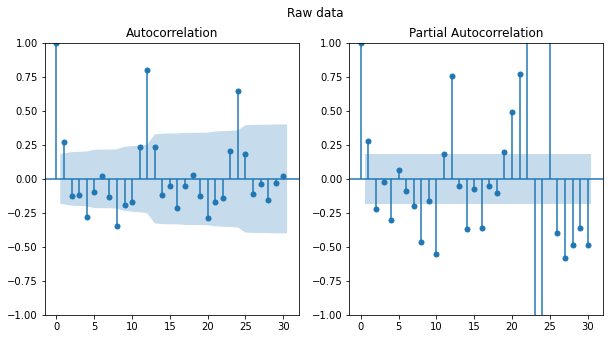

In [93]:
# 차분한 결과 acf pacf 보기 
fig,ax = plt.subplots(1,2,figsize=(10,5))

fig.suptitle("Raw data")
# acf, pacf plt 그리기 

plot_acf(diff_train_data.values.squeeze(),lags=30,ax=ax[0])
plot_pacf(diff_train_data.values.squeeze(),lags=30,ax=ax[1])

## Graphical method로 identification ARIMA model 


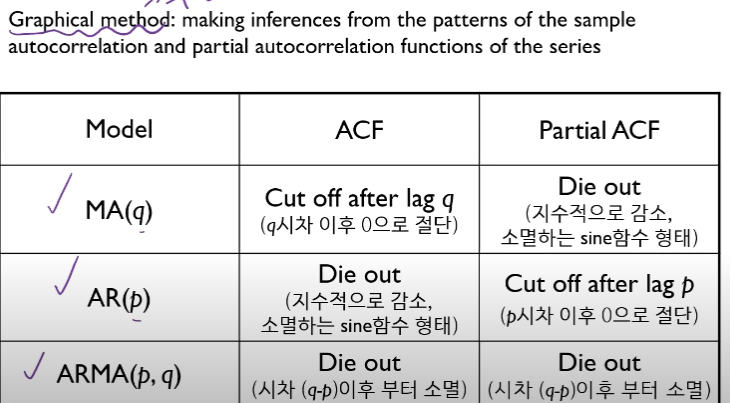


<br>
</br>


위를 보면 sine 함수 형태로 감소 하니까 AR 모델이라고 보고 적용 할것이다 
p를 1로 생각하고 진행 한다 

<br>
</br>

영상에서는 train data를 사용했는데 differencing 한 것을 사용해야 하는거 아닌가? 

-> api에서는 train data 받는게 맞는것 같은데 이럴거면 differencing 어디서 사용됨?

A : 아리마 모델 돌릴때 d의 정보를 주잖아 그러니까 그때 해결이 되는거야   
differencing은 그냥 확인하는 차원에서 그려 본것이라고 이해하면 될듯  ㅇㅇ    


## auto arima 

너무 맹신 하면 안됨 
https://assaeunji.github.io/statistics/2021-09-08-arimapdq/  


<br>
</br>


1. auto_arima 과정을 거치기 전에 시계열 자료를 시각화하는 과정,  
    * trend 와 seasonality , cycle 눈으로 확인하기 위함이다 
    * 분산을 안정화 해줄 필요가 있는지 파악 해야한다 -> 로그 변환
 
 
<br>
</br>
 
2. auto_arima 과정을 거친 후에 모델 적합 후의 잔차가 백색잡음인지, 정상성을 만족하는지 확인하는 과정

<br>
</br>

summary()에서  Ljung-Box (Q) / Heteroskedasticity (H) / Jarque-Bera (JB) 가 잔차에 관한 부분이다 

**plot diagnostics()를 통해 얻은 잔차 그래프로도 확인 가능하다**


<br>
</br>


https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/


<br>
</br>


In [94]:
model =sm.tsa.arima.ARIMA(train_data.values,order=(1,1,0))

model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -532.268
Date:                Mon, 21 Nov 2022   AIC                           1068.536
Time:                        10:49:53   BIC                           1074.008
Sample:                             0   HQIC                          1070.757
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2904      0.089      3.278      0.001       0.117       0.464
sigma2       664.7320     89.253      7.448      0.000     489.800     839.664
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.57   Prob(JB):                         0.20
Heteroskedasticity (H):               6.18   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
# Grid search 

p = range(0,3)
d=range(1,3)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

aic=[]

for i in pdq:
    model = sm.tsa.arima.ARIMA(train_data.values,order=(i))
    model_fit = model.fit()
    print("ARIMA {} >> AIC {}".format(i,round(model_fit.aic,2)))
    aic.append(round(model_fit.aic,2))
    
    

ARIMA (0, 1, 0) >> AIC 1076.27
ARIMA (0, 1, 1) >> AIC 1063.65
ARIMA (0, 1, 2) >> AIC 1060.69
ARIMA (0, 2, 0) >> AIC 1105.71
ARIMA (0, 2, 1) >> AIC 1072.85
ARIMA (0, 2, 2) >> AIC 1060.35
ARIMA (1, 1, 0) >> AIC 1068.54
ARIMA (1, 1, 1) >> AIC 1058.25
ARIMA (1, 1, 2) >> AIC 1057.33
ARIMA (1, 2, 0) >> AIC 1101.1
ARIMA (1, 2, 1) >> AIC 1065.18
ARIMA (1, 2, 2) >> AIC 1054.89
ARIMA (2, 1, 0) >> AIC 1065.64
ARIMA (2, 1, 1) >> AIC 1058.65
ARIMA (2, 1, 2) >> AIC 1057.52
ARIMA (2, 2, 0) >> AIC 1089.69
ARIMA (2, 2, 1) >> AIC 1062.39
ARIMA (2, 2, 2) >> AIC 1056.17


In [96]:
# aic 작은게 좋은거임 

optimal = [(pdq[i],j) for i,j in enumerate(aic) if j==min(aic)]
optimal

[((1, 2, 2), 1054.89)]

In [97]:
model_opt = sm.tsa.arima.ARIMA(train_data.values,order=optimal[0][0])
model_opt_fit = model_opt.fit()
print(model_opt_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -523.445
Date:                Mon, 21 Nov 2022   AIC                           1054.889
Time:                        10:49:54   BIC                           1065.799
Sample:                             0   HQIC                          1059.316
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5137      0.123     -4.192      0.000      -0.754      -0.274
ma.L1         -0.0843     13.864     -0.006      0.995     -27.258      27.089
ma.L2         -0.9155     12.671     -0.072      0.9

In [98]:
from pmdarima.arima import auto_arima

model_arima= auto_arima(train_data,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)

model_arima.fit(train_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1076.519, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1064.624, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1061.078, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1069.440, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1058.834, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1066.203, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1068.094, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1061.649, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercep

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

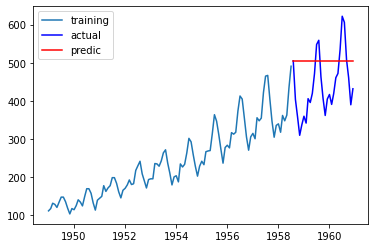

In [99]:
# 시각화 하기 

"""
영상과 다르다 왜 다른지는 잘 모르겠다 

"""
prediction = model_opt_fit.forecast(len(test_data))
pred_series = pd.Series(prediction[0],index = test_data.index)

plt.plot(train_data,label = "training")
plt.plot(test_data,c='b',label="actual")
plt.plot(pred_series,c="r",label="predic")
plt.legend()
plt.show()




In [100]:
r2 = r2_score(test_data,pred_series)
r2

-0.6916078941852084

### SARIMA model로 적용 시켜 보기 

In [101]:
# Grid search 

p = range(0,3)
d=range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))] # 12계절이라고 생각해서 넣은거임 

aic=[]
params=[]

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values,order=(i),seasonal_order=(j))
            model_fit = model.fit()
            print("SARIMA {} >> AIC {}".format(i,round(model_fit.aic,2)))
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
        except:
            continue
    
   # 중간중간 연산이 안되는게 있어서 warining 뜨는것이다 


SARIMA (0, 1, 0) >> AIC 757.83
SARIMA (0, 1, 0) >> AIC 756.99
SARIMA (0, 1, 0) >> AIC 758.83
SARIMA (0, 1, 0) >> AIC 756.96
SARIMA (0, 1, 0) >> AIC 758.92
SARIMA (0, 1, 0) >> AIC 754.42
SARIMA (0, 1, 0) >> AIC 758.87
SARIMA (0, 1, 0) >> AIC 760.73


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA (0, 1, 0) >> AIC 754.89
SARIMA (0, 1, 1) >> AIC 756.01
SARIMA (0, 1, 1) >> AIC 756.38
SARIMA (0, 1, 1) >> AIC 757.65
SARIMA (0, 1, 1) >> AIC 756.17
SARIMA (0, 1, 1) >> AIC 758.11
SARIMA (0, 1, 1) >> AIC 751.73
SARIMA (0, 1, 1) >> AIC 757.99
SARIMA (0, 1, 1) >> AIC 753.78


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA (0, 1, 1) >> AIC 73.35
SARIMA (0, 1, 2) >> AIC 757.78
SARIMA (0, 1, 2) >> AIC 758.04
SARIMA (0, 1, 2) >> AIC 759.28
SARIMA (0, 1, 2) >> AIC 757.81
SARIMA (0, 1, 2) >> AIC 759.75
SARIMA (0, 1, 2) >> AIC 753.5
SARIMA (0, 1, 2) >> AIC 759.64
SARIMA (0, 1, 2) >> AIC 755.49
SARIMA (1, 1, 0) >> AIC 755.5
SARIMA (1, 1, 0) >> AIC 755.98
SARIMA (1, 1, 0) >> AIC 757.1
SARIMA (1, 1, 0) >> AIC 755.75
SARIMA (1, 1, 0) >> AIC 757.65
SARIMA (1, 1, 0) >> AIC 751.15
SARIMA (1, 1, 0) >> AIC 757.45
SARIMA (1, 1, 0) >> AIC 752.99


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA (1, 1, 0) >> AIC 759.62
SARIMA (1, 1, 1) >> AIC 756.02
SARIMA (1, 1, 1) >> AIC 756.63
SARIMA (1, 1, 1) >> AIC 757.75
SARIMA (1, 1, 1) >> AIC 756.41
SARIMA (1, 1, 1) >> AIC 758.26


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA (1, 1, 1) >> AIC 752.53
SARIMA (1, 1, 1) >> AIC 758.03
SARIMA (1, 1, 1) >> AIC 754.17


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA (1, 1, 1) >> AIC 760.27
SARIMA (1, 1, 2) >> AIC 757.92
SARIMA (1, 1, 2) >> AIC 758.44
SARIMA (1, 1, 2) >> AIC 759.63
SARIMA (1, 1, 2) >> AIC 758.22
SARIMA (1, 1, 2) >> AIC 760.1
SARIMA (1, 1, 2) >> AIC 754.53
SARIMA (1, 1, 2) >> AIC 759.92


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA (1, 1, 2) >> AIC 756.16
SARIMA (2, 1, 0) >> AIC 756.77
SARIMA (2, 1, 0) >> AIC 757.23
SARIMA (2, 1, 0) >> AIC 758.31
SARIMA (2, 1, 0) >> AIC 756.98
SARIMA (2, 1, 0) >> AIC 758.86
SARIMA (2, 1, 0) >> AIC 752.78
SARIMA (2, 1, 0) >> AIC 758.65
SARIMA (2, 1, 0) >> AIC 754.51
SARIMA (2, 1, 0) >> AIC 761.1
SARIMA (2, 1, 1) >> AIC 757.98


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA (2, 1, 1) >> AIC 758.54
SARIMA (2, 1, 1) >> AIC 759.69
SARIMA (2, 1, 1) >> AIC 758.31
SARIMA (2, 1, 1) >> AIC 760.18


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA (2, 1, 1) >> AIC 754.54
SARIMA (2, 1, 1) >> AIC 759.98
SARIMA (2, 1, 1) >> AIC 756.17


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA (2, 1, 1) >> AIC 762.4
SARIMA (2, 1, 2) >> AIC 755.2
SARIMA (2, 1, 2) >> AIC 755.99
SARIMA (2, 1, 2) >> AIC 759.77
SARIMA (2, 1, 2) >> AIC 755.82
SARIMA (2, 1, 2) >> AIC 757.71
SARIMA (2, 1, 2) >> AIC 752.34
SARIMA (2, 1, 2) >> AIC 757.56


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA (2, 1, 2) >> AIC 753.96
SARIMA (2, 1, 2) >> AIC 760.4


C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [102]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j== min(aic)]
optimal

[(((0, 1, 1), (2, 1, 2, 12)), 73.35)]

In [103]:
model_opt = SARIMAX(train_data.values,order=optimal[0][0][0],seasonal_order=optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

C:\Users\maeng\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                 -30.676
Date:                                 Mon, 21 Nov 2022   AIC                             73.353
Time:                                         10:51:18   BIC                             89.102
Sample:                                              0   HQIC                            79.730
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0332   3.56e-07   9.32e+04      0.000       0.033       0.033
ar.S.L12       0.0014   1.78e-07   7840.417      0.000       0.001       0.001
ar.S.L24       0.9986   3.17e-07   3.15e+06      0.000       0.999       0.999
ma.S.L12       0.0004   2.57e-07   1689.086      0.000       0.000       0.000
ma.S.L24      -0.9951   3.02e-08  -3.29e+07      0.000      -0.995      -0.995
sigma2        81.4345   7.19e-10   1.13e+11      0.000      81.435      81.435
===================================================================================
Ljung-Box (L1) (Q):                  21.56   Jarque-Bera (JB):             12284.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             6.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.72e+21. Standard errors may be unstable.
"""

In [114]:
prediction = model_opt_fit.get_forecast(len(test_data))
prediction_val  = prediction.predicted_mean
predicted_up = prediction.conf_int()[:,0]

predicted_lb = prediction.conf_int()[:,1]

predict_index = list(test_data.index)
r2 = r2_score(test_data,prediction_val)


r2



-75518.99618095055

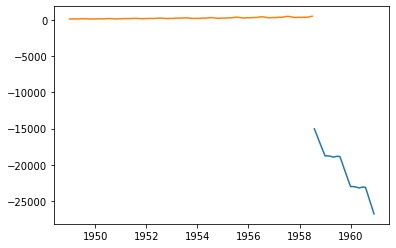

In [105]:
plt.plot(predict_index,prediction_val,label="prediction")
plt.plot(train_data)

In [108]:
print("SARIMA {} PRED {}".format((optimal[0][0][0],optimal[0][0][1]),round(r2,2)))

SARIMA ((0, 1, 1), (2, 1, 2, 12)) PRED -75519.0


In [115]:

# auto arima 적용 

auto_arima_model = auto_arima(train_data,start_p=1,start_q=1,max_p=3,
                             max_q=3,m=12,seasonal=True,
                             d=1,D=1,max_P=3,max_Q=3,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.36 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.45 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.20 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.12 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.60 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=1.91 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.47 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=2.06 sec
 ARIMA(0,1,1)(0,1,0)[1

In [117]:
auto_arima_model.summary() # 자동으로 최적값 적용되었다고 보니까 바로 summary해도 됨 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Mon, 21 Nov 2022   AIC                            752.557
Time:                                            11:10:34   BIC                            768.307
Sample:                                        01-01-1949   HQIC                           758.934
                                             - 07-01-1958                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.657     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [118]:
prediction = auto_arima_model.predict(len(test_data),return_conf_int=True)
r2 =r2_score(test_data,prediction[0])
r2 # 드디어 제대로 된 값이 나온다 

0.883621692013935

refreshing 하는게 중요하다 그래야 과거의 데이터 가지고 미래를 예측 하지 않는다 

